In [1]:
from training_data import import_training_set

data, weights, rulesetIds = import_training_set("components classification")

In [2]:
data

,Selection 1 - ProgressiveHistory,Selection 1 - Random,Selection 1 - UCB1,Selection 1 - UCB1GRAVE,Selection 1 - UCB1Tuned,Selection 2 - ProgressiveHistory,Selection 2 - Random,Selection 2 - UCB1,Selection 2 - UCB1GRAVE,Selection 2 - UCB1Tuned,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Most common outcome for Agent 1
0,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,Win
1,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Win
2,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,Loss
3,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,Win
4,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17877,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,Win
17878,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,Win
17879,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,Win
17880,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,Loss


In [3]:
weights

0        0.612842
1        0.612842
2        0.612842
3        0.612842
4        0.612842
           ...   
17877    0.987500
17878    0.987500
17879    0.987500
17880    0.987500
17881    0.987500
Name: 0, Length: 17882, dtype: float64

In [4]:
rulesetIds

0         37
1         37
2         37
3         37
4         37
        ... 
17877    456
17878    456
17879    456
17880    456
17881    456
Name: 0, Length: 17882, dtype: category
Categories (1017, int64): [17, 18, 30, 33, ..., 4096, 4118, 4186, 4187]

Progress: 50/1017; Time elapsed (s): 20.56; Estimated time left (s): 397.64
Progress: 100/1017; Time elapsed (s): 41.08; Estimated time left (s): 376.73
Progress: 150/1017; Time elapsed (s): 61.68; Estimated time left (s): 356.49
Progress: 200/1017; Time elapsed (s): 82.37; Estimated time left (s): 336.49
Progress: 250/1017; Time elapsed (s): 103.19; Estimated time left (s): 316.59
Progress: 300/1017; Time elapsed (s): 123.96; Estimated time left (s): 296.26
Progress: 350/1017; Time elapsed (s): 144.67; Estimated time left (s): 275.69
Progress: 400/1017; Time elapsed (s): 165.45; Estimated time left (s): 255.21
Progress: 450/1017; Time elapsed (s): 186.13; Estimated time left (s): 234.52
Progress: 500/1017; Time elapsed (s): 206.80; Estimated time left (s): 213.83
Progress: 550/1017; Time elapsed (s): 227.75; Estimated time left (s): 193.38
Progress: 600/1017; Time elapsed (s): 248.34; Estimated time left (s): 172.60
Progress: 650/1017; Time elapsed (s): 268.95; Estimated time left (s)

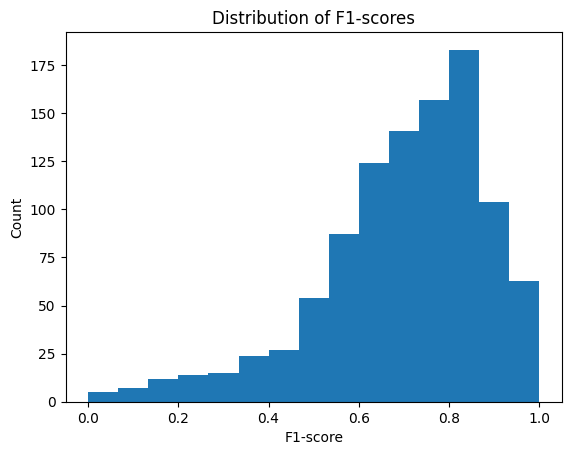

In [5]:
import time
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Prepare data
X = data.drop(columns=["Most common outcome for Agent 1"])
y = data["Most common outcome for Agent 1"]

# Custom implementation of Leave-One-Out Cross-Validation
scores = []
rulesetWeights = []
featureImportance = {}

startTime = time.time()
noIterations = 0
noRulesets = rulesetIds.unique().shape[0]

for rulesetId in rulesetIds.unique():
    # Train/test split
    trainIdx = (rulesetIds != rulesetId)
    X_train = X[trainIdx]
    y_train = y[trainIdx]

    testIdx = (rulesetIds == rulesetId)
    X_test = X[testIdx]
    y_test = y[testIdx]

    # Train classifier
    clf = DecisionTreeClassifier().fit(X_train, y_train, sample_weight=weights[trainIdx])

    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Determine performance of classifier
    scores.append(f1_score(y_test, y_pred, average="weighted"))
    
    # Log other important information
    rulesetWeights.append(weights[testIdx].iloc[0])
    featureImportance[rulesetId] = clf.feature_importances_
    
    # Output progress
    noIterations += 1
    if noIterations % 50 == 0:
        elapsedTime = time.time() - startTime
        avgTimePerIteration = elapsedTime / noIterations
        print(f"Progress: {noIterations}/{noRulesets}; Time elapsed (s): {elapsedTime:.2f}; Estimated time left (s): {(noRulesets - noIterations) * avgTimePerIteration:.2f}")

print(f"Progress: {noIterations}/{noRulesets}; Time elapsed (s): {time.time() - startTime:.2f}")

# Output results
print(f"\n-- Results (F1-score) --")
print(f"Minimum: {np.min(scores):.3f}\nMaximum: {np.max(scores):.3f}")
print(f"\nUnweighted average: {np.average(scores):.3f}\nWeighted average: {np.average(scores, weights=rulesetWeights):.3f}")
print(f"\nStd: {np.std(scores):.3f}")

plt.hist(scores, bins=15)
plt.xlabel("F1-score")
plt.ylabel("Count")
plt.title("Distribution of F1-scores");

In [6]:
import pandas as pd

featureImportance = pd.DataFrame.from_dict(featureImportance, orient="index", columns=X.columns)

# Rank features from most to least important
avgFeatureImportance = featureImportance.mean()
order = avgFeatureImportance.argsort()
avgFeatureImportance.iloc[order[::-1]]

Selection 1 - Random                1.410771e-01
Play-out 1 - Random                 1.364435e-01
Selection 2 - Random                6.417634e-02
Play-out 2 - Random                 6.133901e-02
Exploration 1                       2.256154e-02
                                        ...     
SpiralTiling                        4.515088e-07
AlquerqueBoardWithEightTriangles    6.568976e-20
SpiralShape                         1.111493e-20
LeftwardsDirection                  7.902089e-21
RightwardsDirection                 6.952896e-21
Length: 184, dtype: float64

In [7]:
# Adding weights:
# (V) Add weights to training of classifier
# (V) Compute weighted average of f1-score
# (X) Compute weighted standard deviation of f1-score (?)
# (X) Change from unweighted to weighted average feature importance